<a href="https://colab.research.google.com/github/tzopiz/TMJ/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# colab не может найти зависимость
# !pip install -r requirements.txt

In [1]:
import random
import albumentations as A

from os.path import join as pjoin

import matplotlib.pyplot as plt
import numpy as np
from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from train import (
    CheckpointSaver,
    load_checkpoint,
    train
)

from LossFunc.MulticlassDiceLoss import MulticlassDiceLoss
from MetricFunc.IoUMetric import IoUMetric

from helpy.helpy import *
from helpy.helpy_visualize import *
from helpy.helpy_calculate import *

from TMJDataset import TMJDataset
from unet import UNet

In [2]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

In [3]:
IMAGE_SIZE = 512

# Базовые преобразования
basic_transforms = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),  # Изменение размера
    A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, p=1.0),  # Добавление паддинга
    A.CropNonEmptyMaskIfExists(height=IMAGE_SIZE, width=IMAGE_SIZE),  # Обрезка
    A.HorizontalFlip(p=0.5)  # Случайный горизонтальный флип
])

# Агрессивные преобразования, с уменьшением вероятности применения сильных аугментаций
aggressive_transforms = A.Compose([
    A.OneOf([
        A.AdvancedBlur(p=0.5),  # Меньше размытости
        A.CLAHE(p=0.5),  # Меньше CLAHE
    ], p=0.3),  # Применяется с меньшей вероятностью

    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),  # Случайная яркость и контраст
        A.RandomGamma(p=0.5),  # Случайная гамма
        A.ColorJitter(p=0.5),  # Случайное изменение яркости, контраста и насыщенности
    ], p=0.3),  # Применяется с вероятностью 50%

    A.Rotate(limit=15, p=0.3),  # Меньше поворота, чтобы сохранить форму маленьких объектов
    A.ElasticTransform(alpha=1, sigma=50, p=0.5),  # Эластичные деформации
])

# Итоговая трансформация, где сначала применяются базовые, затем агрессивные
transforms = A.Compose([
    basic_transforms,  # Базовые преобразования
    aggressive_transforms,  # Агрессивные преобразования
    ToTensorV2(),  # Преобразование в тензор
])

In [4]:
full_dataset = TMJDataset(
    image_dir="full_dataset/images",
    mask_dir="full_dataset/masks",
    transforms=transforms
)

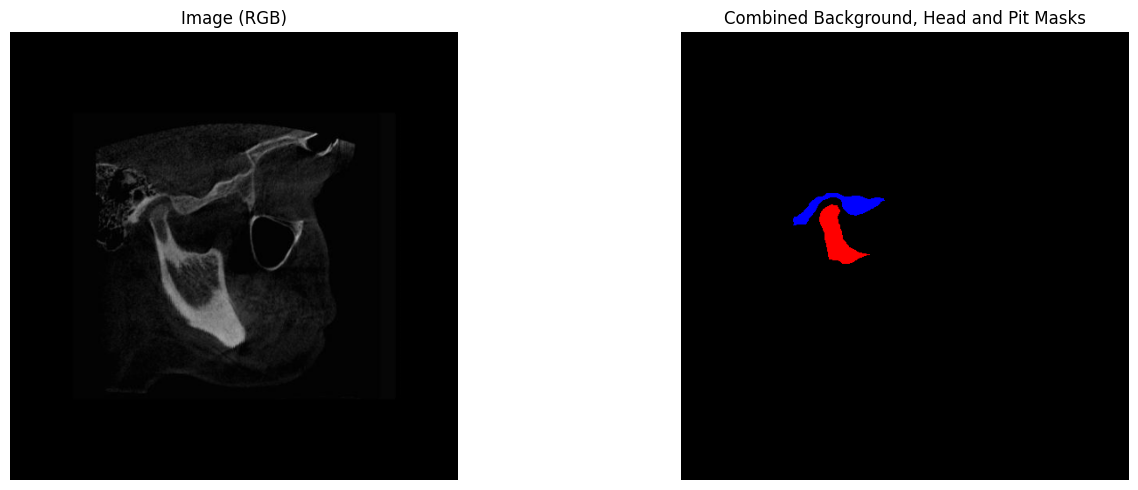

In [5]:
full_dataset.visualize(0)

In [6]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print('Количество изображений в полном датасете:',len(full_dataset))
print('Количество изображений в тренировочном датасете:',len(train_dataset))
print('Количество изображений в валидационном датасете:',len(val_dataset))
print('Количество изображений в тестовом датасете:',len(test_dataset))

Количество изображений в полном датасете: 163
Количество изображений в тренировочном датасете: 114
Количество изображений в валидационном датасете: 32
Количество изображений в тестовом датасете: 17


## Обучение модели

In [7]:
CLASSES_NUM = 2

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
BETAS = (0.8, 0.999)
BATCH_SIZE = 16
NUM_WORKERS = 4
EPOCH_NUM = 150
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False
# CLASS_WEIGHTS = compute_class_weights(dataset=full_dataset, num_classes=CLASSES_NUM)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    drop_last=True,
)

accelerator = Accelerator(cpu=False, mixed_precision="fp16")
model = UNet(in_channels=3, out_channels=CLASSES_NUM)

loss_fn = MulticlassDiceLoss()
metric_fn = IoUMetric(classes_num=CLASSES_NUM, reduction="macro")

optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=BETAS
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=10, gamma=0.85
)

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="mIoU",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)

ValueError: fp16 mixed precision requires a GPU (not 'mps').

In [ ]:
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

In [ ]:
# акселерируем
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

In [ ]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
    show_every_x_batch=15,
)

In [9]:
model = UNet(in_channels=3, out_channels=CLASSES_NUM)
model = load_checkpoint(
    model=model, load_path=pjoin(CHECKPOINTS_DIR, "model_checkpoint_best.pt")
)
model = model.to(DEVICE)
model.eval();

In [ ]:
visualize_prediction(
    model=model,
    dataset=test_dataset,
    index=0,
    device=DEVICE,
    threshold=0.5
)

In [ ]:
# Пример использования
from skimage.morphology import dilation, disk
image, mask_tensor = test_dataset[0]
areas = calculate_areas(mask_tensor)
scaled_mask = scale_head_mask(mask_tensor)
scaled_mask = dilation(scaled_mask, disk(7)) 
p_top, p_dist, (x, y) = calculate_back_axes(scaled_mask)
height = calculate_head_height(mask_tensor, intersection_point= (x, y))
print(f'areas = {areas}')
print(f'Верхняя точка = ({p_top[0]}, {p_top[1]})')
print(f'Дистальная точка = ({p_dist[0]}, {p_dist[1]})')
print(f'Начало координат = ({x}, {y})')
print(f'Высота сутавной головки = {height}')

In [ ]:
visualize_with_axes(scaled_mask, x, y, height=height)

In [ ]:
bot_x, bot_y = find_intersection(mask=scaled_mask, x_coord=x)
angle = calculate_angle(p1=p_top, p2=p_dist, p3=(bot_x, bot_y))

print(f'Задний суставной угол = {angle}')

In [ ]:
visualize_with_back_angle(scaled_mask, p_top, p_dist, (bot_x, bot_y), angle=angle)

In [ ]:
from skimage.morphology import dilation, disk
dilated_mask = dilation(scaled_mask, disk(7)) 
visualize_with_back_angle(dilated_mask, p_top, p_dist, (bot_x, bot_y), angle=angle)
visualize_with_axes(dilated_mask, x, y, height=height)

In [ ]:
x, y, z = calculate_front_axes(scaled_mask)

plt.figure(figsize=(7, 7))
plt.imshow(scaled_mask, cmap='binary')
    
ys, xs = np.where(scaled_mask > 0)

plt.scatter(x[0], x[1], color='blue', s=20)
plt.scatter(y[0], y[1], color='red', s=20)

plt.scatter(z[0], z[1], color='yellow', s=20)
# plt.scatter(x_top, y_top, color='yellow', s=20)
# plt.scatter(x_bot, y_bot, color='yellow', s=20)

plt.show()

In [ ]:
front_angle = calculate_angle(p1=(x_top, y_top), p2=z, p3=(x_bot, y_bot))
print(f'Передний суставной угол = {front_angle}')

visualize_with_back_angle(scaled_mask, (x_top, y_top), z, (x_bot, y_bot), angle=front_angle)